#Data pre-processing

In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).





##Inspecting the Dataset



---




In [386]:
# Load Datase
path = "/content/drive/My Drive/data/marketing_campaign.csv"
df = pd.read_csv(path, sep='\t') 

# View column names, non-null count and dtype
print(df.info()) 

# View the first 5 rows
pd.set_option('display.max_columns', None)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0




## 1. Data preprocessing/cleaning
---


### Handle missing values

*After inspecting the dataset with df.info(), we found that only the Income column has missing values.*

In [387]:
print("Total Income missing values:" , df.Income.isnull().sum())

Total Income missing values: 24


*As there are only a small number of missing values (24 out of 2240 rows), we can safely remove the rows with missing values to avoid any potential bias or errors in our analysis.*

In [388]:
df.dropna(subset=['Income'], inplace=True)
print("Total Income missing values:" , df.Income.isnull().sum())

Total Income missing values: 0


### Handle dates

Convert the Dt_Customer column from object type to datetime format.This allows us to perform time-based analysis on customer acquisition *dates*

In [389]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Dt_Customer']

<ipython-input-389-1631629796dd>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])


0      2012-04-09
1      2014-08-03
2      2013-08-21
3      2014-10-02
4      2014-01-19
          ...    
2235   2013-06-13
2236   2014-10-06
2237   2014-01-25
2238   2014-01-24
2239   2012-10-15
Name: Dt_Customer, Length: 2216, dtype: datetime64[ns]

## 2. Marital_Status , Education
---


*Inspect columns*

In [390]:
print("Unique values in Marital_Status:","\n", df['Marital_Status'].unique())
print("\n","Unique values in Education: ","\n", df['Education'].unique())

Unique values in Marital_Status: 
 ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']

 Unique values in Education:  
 ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


*Simplify the categories for Marital_Status*

In [391]:
df['Marital_Status'] = df['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')
print("Unique values in Marital_Status:","\n", df['Marital_Status'].unique())

Unique values in Marital_Status: 
 ['Single' 'Together' 'Married' 'Divorced' 'Widow']


### Distribution of marital status and education

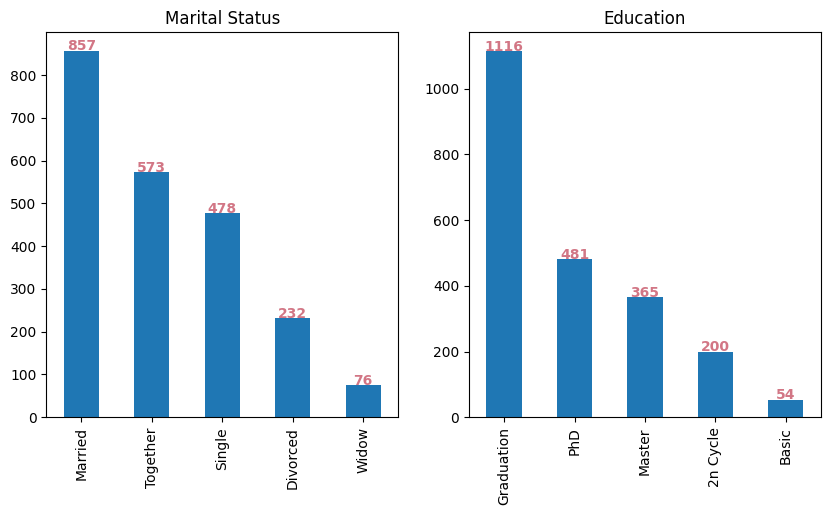

In [392]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

# Bar plot for marital status
counts = df['Marital_Status'].value_counts()
counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Marital Status')
for i, v in enumerate(counts):
    ax[0].text(i, v + 0.5, str(v), color='#D27685', fontweight='semibold', ha='center')

# Bar plot for education
counts = df['Education'].value_counts()
counts.plot(kind='bar', ax=ax[1])
ax[1].set_title('Education')
for i, v in enumerate(counts):
    ax[1].text(i, v + 0.5, str(v), color='#D27685', fontweight='semibold', ha='center')

plt.show()


## 3.  Creating new **features** based on customer behavior
---


### A. **Customer_for**: Days since first and last purchase

In [393]:
import datetime as dt

def calculate_customer_for(customer):

    today = pd.Timestamp.today().normalize()
    first_purchase = pd.to_datetime(customer['Dt_Customer']).normalize()
    #Days passed since latest purchase
    recency = dt.timedelta(days=customer['Recency'])
    return (today - recency - first_purchase).days

df['Customer_For'] = df.apply(calculate_customer_for, axis=1)

df[['Dt_Customer', 'Recency', 'Customer_For']].head(3)

,Dt_Customer,Recency,Customer_For
0,2012-04-09,58,3981
1,2014-08-03,38,3155
2,2013-08-21,26,3514


### B. **Age**: Calculation of Customer Age based on Year of Birth

In [394]:
def calculate_age(year_birth):
    current_year = dt.datetime.now().year
    age = current_year - year_birth
    return age

df['Age'] = df['Year_Birth'].apply(calculate_age)
df[['Year_Birth', 'Age']].head(3)

,Year_Birth,Age
0,1957,66
1,1954,69
2,1965,58


### C. **Spent**: Calculation of Total Amount Spent by Customer in a Two-Year Period

In [154]:
df['Spent'] = df.loc[:, 'MntWines':'MntGoldProds'].sum(axis=1)
df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Spent']].head(2)

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Spent
0,635,88,546,172,88,88,1617
1,11,1,6,2,1,6,27


### D. **Children**: Total number of children in a household, including both kids and teenagers

In [155]:
df['Children'] = df['Kidhome'] + df['Teenhome']
df[['Kidhome', 'Teenhome', 'Children']].head(2)

,Kidhome,Teenhome,Children
0,0,0,0
1,1,1,2


### E. **Family_Size**: Calculate Family Size based on Marital Status and Number of Children

In [156]:
def calculate_family_size(row):
    # Case for 2 adults
    if row['Marital_Status'] == 'Together' or row['Marital_Status'] == 'Married':
        return row['Children'] + 2 
    # Case for 1 adult
    else:
        return row['Children'] + 1 

df['Family_Size'] = df.apply(calculate_family_size, axis=1)

df[['Marital_Status', 'Children', 'Family_Size']].head()

,Marital_Status,Children,Family_Size
0,Single,0,1
1,Single,2,3
2,Together,0,2
3,Together,1,3
4,Married,1,3


### F. **Is_Parent**: Based on the "children" column

In [157]:
df['Is_Parent'] = df['Children'] > 0
df['Is_Parent'] = df['Is_Parent'].astype(int)
df[['Children', 'Is_Parent']].head(2)

,Children,Is_Parent
0,0,0
1,2,1


### G. **Living_With**: Based on Marital_Status

In [158]:
df['Living_With'] = df['Marital_Status'].apply(lambda x: "Partner" if x in ['Married', 'Together'] else "Alone")

df[['Marital_Status', 'Living_With']].head()

,Marital_Status,Living_With
0,Single,Alone
1,Single,Alone
2,Together,Partner
3,Together,Partner
4,Married,Partner


### H. **Age_Group**: Based on Age Group

In [159]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 120]
labels = ['<20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '>80']

df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels)
df[['Age', 'Age_Group']].head()

,Age,Age_Group
0,66,61-70
1,69,61-70
2,58,51-60
3,39,31-40
4,42,41-50


## 4. Check for outliers


---



* *After inspecting the data for max, min, and NaN values, we found that there were 3 customers with an **age** of 120+ who had made recent purchases. Given that it is highly unusual for customers to be active at such an advanced age, we have decided to remove these entries from our dataset, assuming that they are **extreme values**. As a result, we have removed the three entries with ages greater than or equal to 120.*
* *Similarly, we also noticed 8 **outliers** values in the **income** column.*



In [160]:
df.loc[df['Age'] > 80, ['Age', 'Recency', 'Dt_Customer' ]]

,Age,Recency,Dt_Customer
192,123,99,2013-09-26
239,130,23,2014-05-17
339,124,36,2013-09-26
424,82,77,2013-04-13
1950,83,96,2013-08-07


In [161]:
#Remove extreme values for 'Age'
max_age_indices = df['Age'].nlargest(3).index
df = df.drop(max_age_indices)
df.loc[df['Age'] > 80, ['Age', 'Recency', 'Dt_Customer' ]]

,Age,Recency,Dt_Customer
424,82,77,2013-04-13
1950,83,96,2013-08-07


2233    666666.0
617     162397.0
687     160803.0
1300    157733.0
164     157243.0
1653    157146.0
2132    156924.0
655     153924.0
1898    113734.0
646     105471.0
Name: Income, dtype: float64


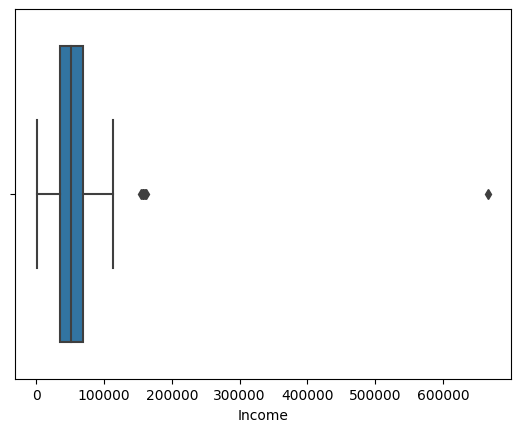

In [395]:
# Plot a box plot for the income column
sns.boxplot(data=df, x='Income')
largest_incomes = df['Income'].nlargest(10)
print(largest_incomes)

<Axes: xlabel='Income'>

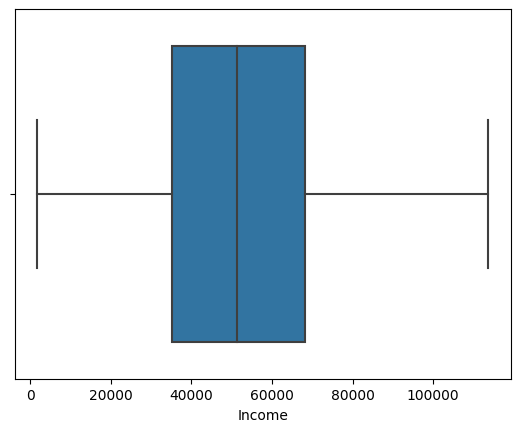

In [396]:
# Remove top 8 rows
df = df.drop(df['Income'].nlargest(8).index)

# Plot a box plot for the updated Income column
sns.boxplot(data=df, x='Income')

## 5. Exploring the Correlation between some of the Numeric Features using Heatmap


---


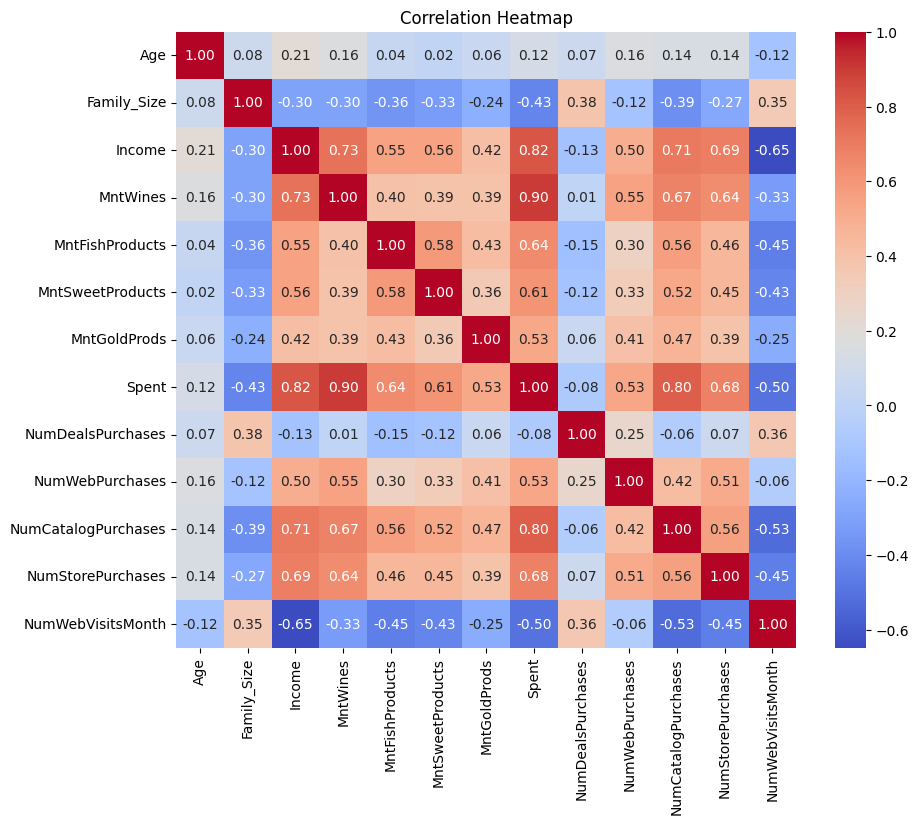

In [164]:
# Create a new dataframe with selected columns
corr_df = df[['Age', 'Family_Size', 'Income', 'MntWines', 'MntFishProducts', 'MntSweetProducts','MntGoldProds', 'Spent', 'NumDealsPurchases', 'NumWebPurchases', 
              'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']]

# Calculate the correlation matrix
corr = corr_df.corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## 6. Plotting Insights: Analyzing Data with Visualizations

---


### 1) Distribution of Customers by Marital Status

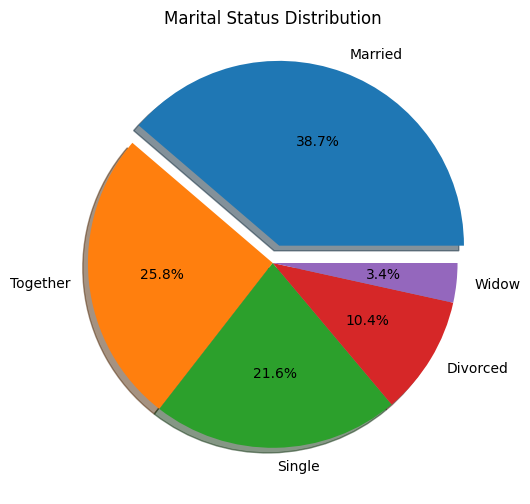

In [165]:
fig, ax = plt.subplots(figsize=(6, 6))

# Calculate percentage of customers in each marital status category
marital_status = df['Marital_Status'].value_counts(normalize=True) * 100

# Create a pie chart and highlight the category with the highest percentage
explode = [0.1 if i == marital_status.idxmax() else 0 for i in marital_status.index]
plt.pie(marital_status.values, labels=marital_status.index, autopct='%1.1f%%', explode=explode, shadow=True)

# Add a title
plt.title('Marital Status Distribution')

# Show the plot
plt.show()


### 2) Number of customers who made a Complain

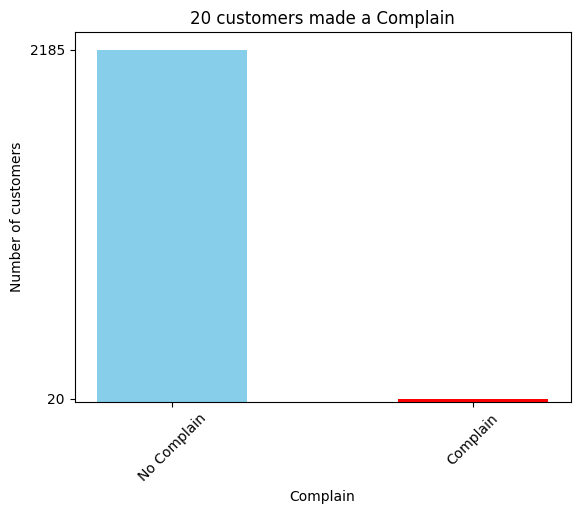

In [166]:
complains = df['Complain'].value_counts()
labels = ['No Complain', 'Complain']

plt.bar(labels, complains, color=['skyblue', 'red'], width=0.5)
num_complains = complains[1]
plt.title(f'{num_complains} customers made a Complain')
plt.ylabel('Number of customers')
plt.xlabel('Complain')
plt.xticks(rotation=45)
plt.yticks(complains.values.astype(int))
plt.show()

### 3) Relation between Marital_Status and Spent

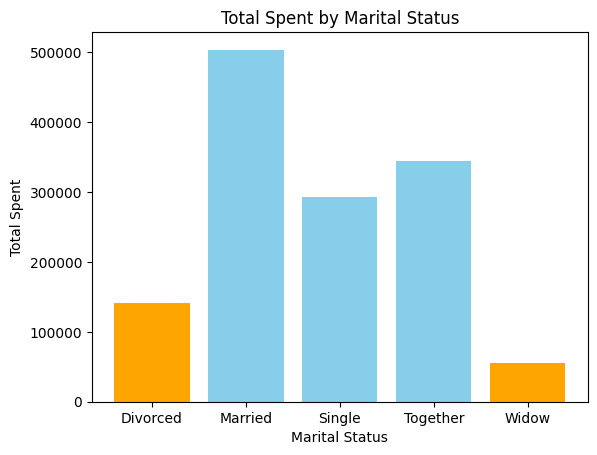

In [167]:
spent_marital = df.groupby('Marital_Status')['Spent'].sum()

# Use different colors for marital status categories with higher vs. lower average spending
# 'Higher' categories are those with spent above the median for all customers
mid_total_mid_total_spent = np.median(spent_marital.values)
colors = ['skyblue' if spent >= mid_total_mid_total_spent else 'orange' for spent in spent_marital.values]

plt.bar(spent_marital.index, spent_marital.values, color=colors)
plt.title('Total Spent by Marital Status')
plt.ylabel('Total Spent')
plt.xlabel('Marital Status')
plt.show()

### 4) Relation between Spent, Family Size, and Children
*Based on the 3D plot, it appears that families with fewer members and children tend to spend more.* 


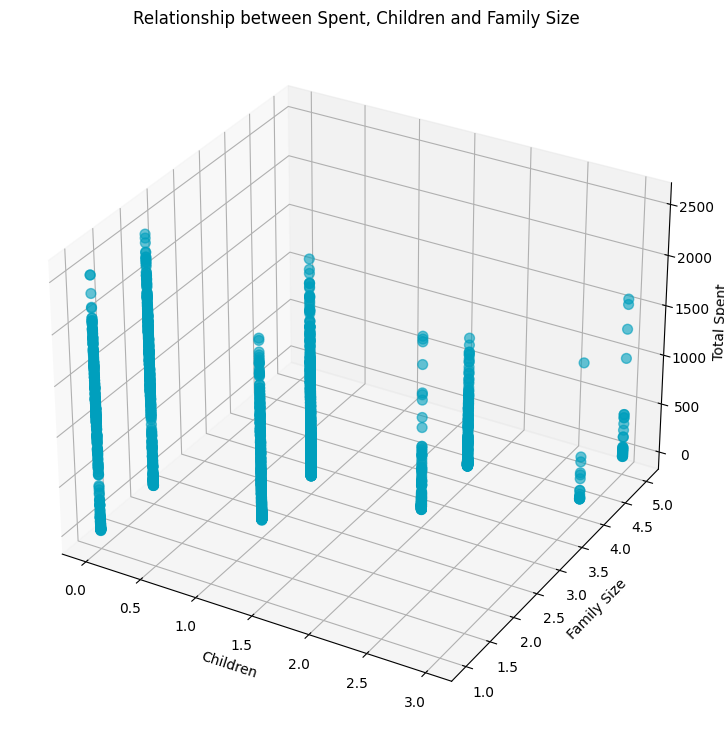

In [198]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

xs = df['Children']
ys = df['Family_Size']
zs = df['Spent']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, color = "#009FBD")

ax.set_xlabel('Children')
ax.set_ylabel('Family Size')
ax.set_zlabel('Total Spent')

plt.title('Relationship between Spent, Children and Family Size')
plt.show()


### 5) Relationship between Age Group and Spent on Purchases

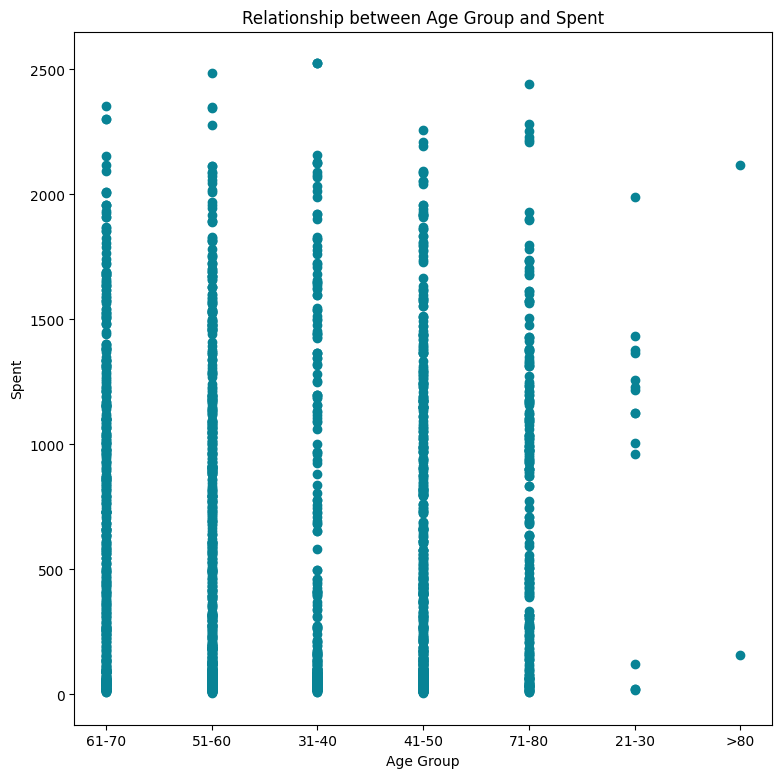

In [215]:
fig = plt.figure(figsize=(9, 9))
# Create a scatter plot of age group vs spent
plt.scatter(df['Age_Group'], df['Spent'], color = "#088395")

# Add axis labels and a title
plt.xlabel('Age Group')
plt.ylabel('Spent')
plt.title('Relationship between Age Group and Spent')

# Show the plot
plt.show()

### 6) Relationship between Income and Spent

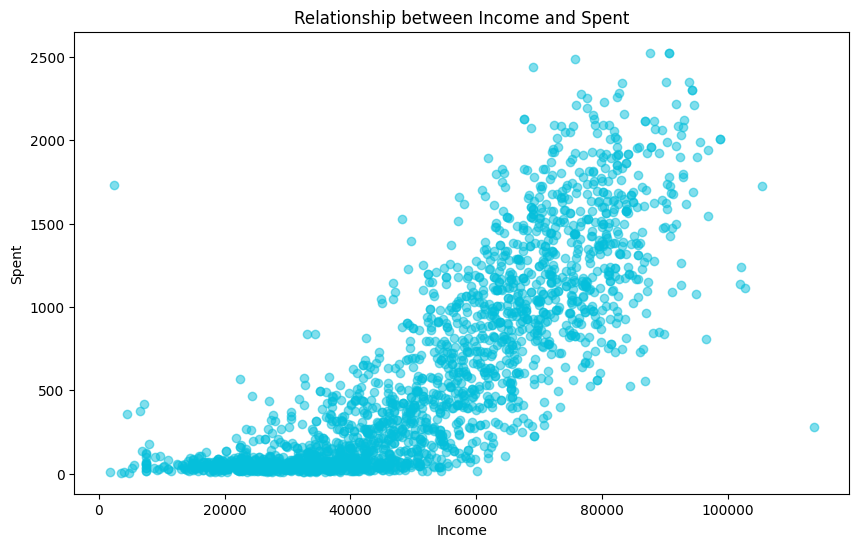

In [216]:
# Plot the relationship between income and spent
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['Income'], df['Spent'], alpha=0.5, color = "#05BFDB")
ax.set_xlabel('Income')
ax.set_ylabel('Spent')
ax.set_title('Relationship between Income and Spent')
plt.show()


### 7) Relationship between Education and Income

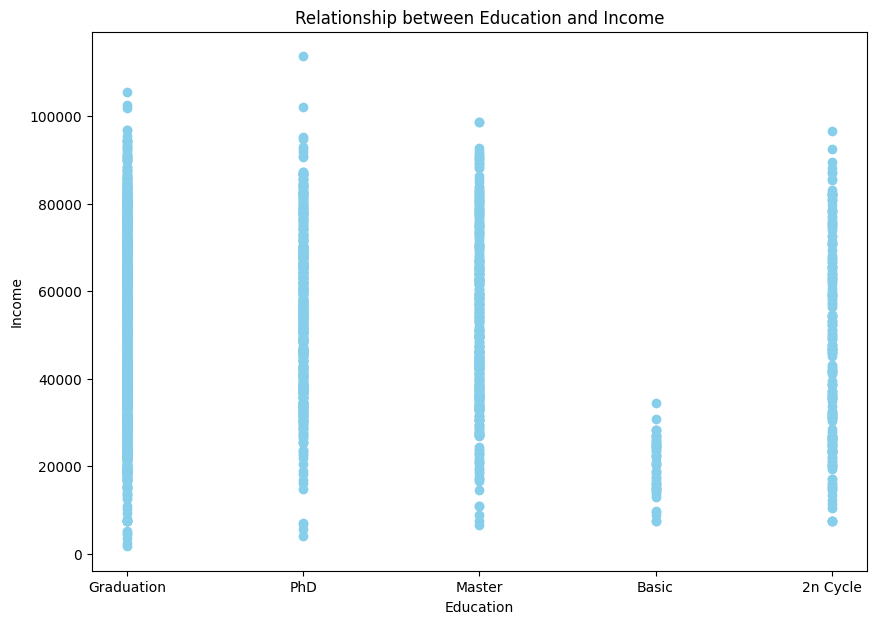

In [218]:
# Create a scatter plot of education vs income
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(df['Education'], df['Income'], color = "skyblue")
ax.set_xlabel('Education')
ax.set_ylabel('Income')
ax.set_title('Relationship between Education and Income')
plt.show()


### 8) Relationship between Income and Family Size

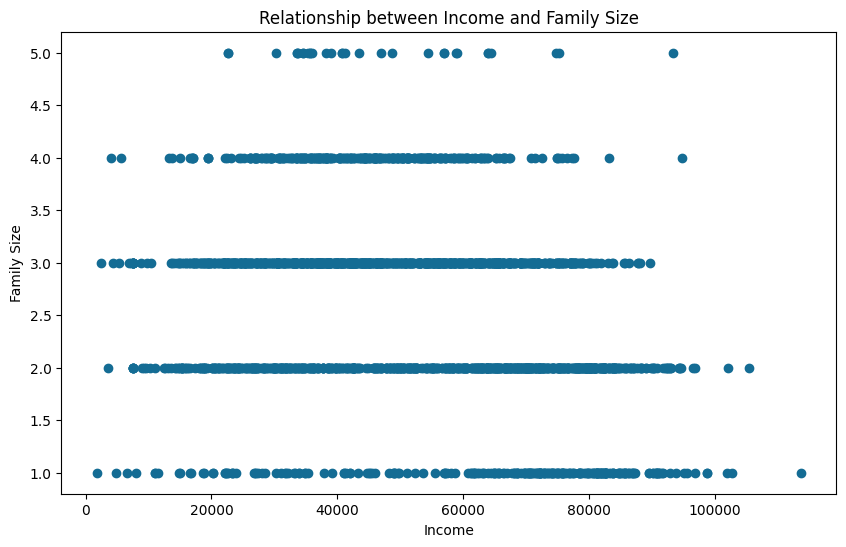

In [220]:
# Create scatter plot of income and family size
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['Income'], df['Family_Size'], color = "#146C94")
ax.set_xlabel('Income')
ax.set_ylabel('Family Size')
ax.set_title('Relationship between Income and Family Size')
plt.show()


### 9) Relationship between Income and number of children

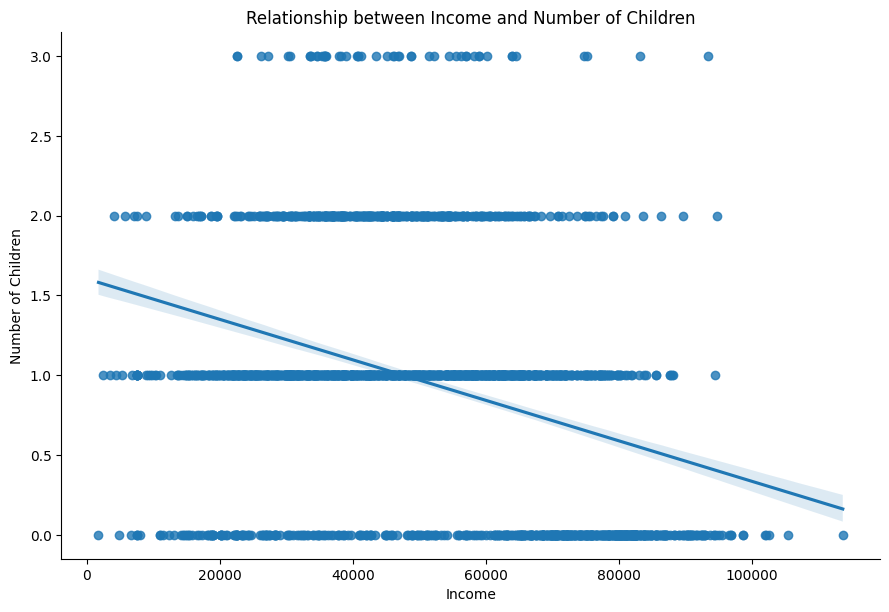

In [226]:
# Create scatter plot of income and number of children
sns.lmplot(x='Income', y='Children', data=df, height=6, aspect=1.5)

# Set plot labels and title
plt.xlabel('Income')
plt.ylabel('Number of Children')
plt.title('Relationship between Income and Number of Children')

# Display the plot
plt.show()


### 10) Relationship between Income and "Living_With"

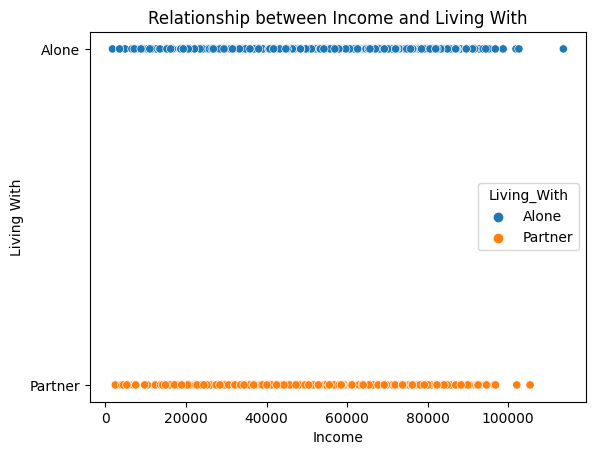

In [233]:
# Create scatter plot with income and Living_With
sns.scatterplot(x='Income', y='Living_With', hue='Living_With', data=df)

# Set title and axis labels
plt.title('Relationship between Income and Living With')
plt.xlabel('Income')
plt.ylabel('Living With')

# Show the plot
plt.show()

### 12) Relationship between web purchases and web visits
*Based on the heatmap, we can observe that there is a weak correlation between the number of web purchases and the number of web visits per month.*

<Axes: >

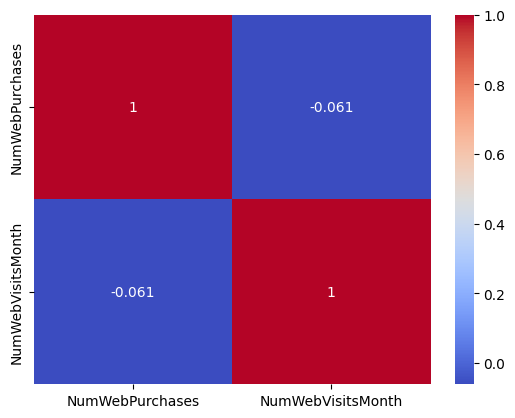

In [238]:
# Create a correlation matrix for the relevant columns
corr_matrix = df[['NumWebPurchases', 'NumWebVisitsMonth']].corr()

# Plot a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


### 13) Percentage of Customers Accepting All Offers
Based on the accept* and response columns, which relate to the offers made by the store, it appears that none of the customers accepted all of the offers *italicized text*

In [252]:
# Calculate the percentage of customers who accepted all offers
all_accepted = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis=1) == 6
percentage_accepted_all = all_accepted.mean() * 100

# Print the percentage
print(f"The percentage of customers who accepted all offers is: {percentage_accepted_all:.2f}%")

The percentage of customers who accepted all offers is: 0.00%


### 14) Create a histogram for the column NumDealsPurchases. 

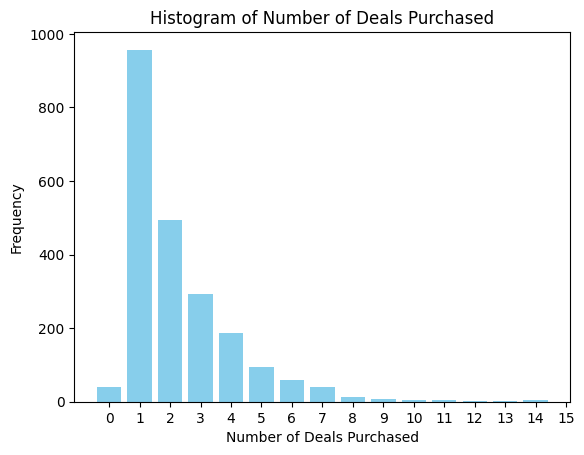

In [261]:

plt.hist(df['NumDealsPurchases'], bins=range(0, 16, 1), align='left', rwidth=0.8, color = "skyblue")
plt.xticks(range(0, 16))
plt.xlabel('Number of Deals Purchased')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Deals Purchased')
plt.show()


### 15) Histogram of Income Column.

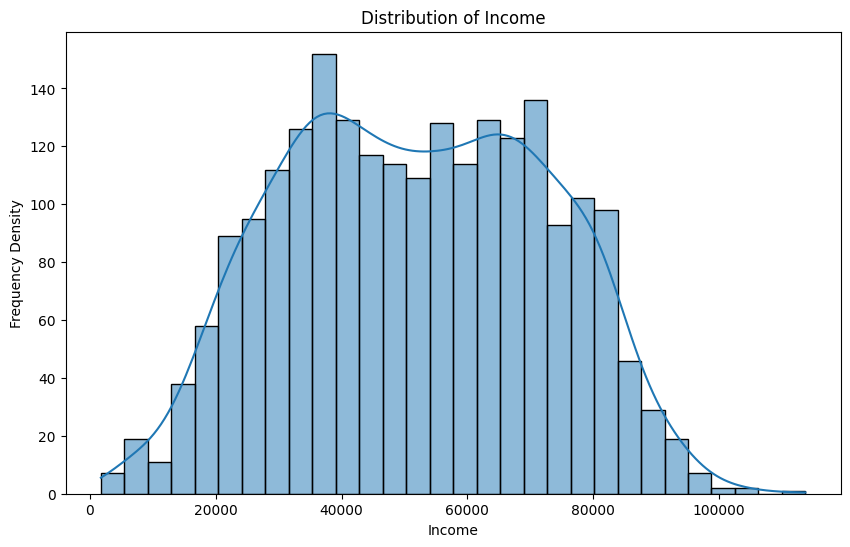

In [270]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=df, x="Income", bins=30, kde=True)
plt.title("Distribution of Income")
plt.xlabel("Income")
plt.ylabel("Frequency Density")
plt.show()

### 16) Histogram of Kidhome.


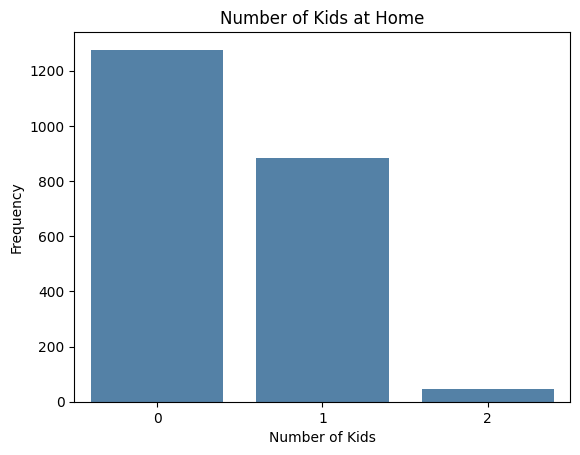

In [283]:
sns.countplot(data=df, x='Kidhome', color='steelblue')
plt.title('Number of Kids at Home')
plt.xlabel('Number of Kids')
plt.ylabel('Frequency')
plt.show()

### 17) Histogram for family size.

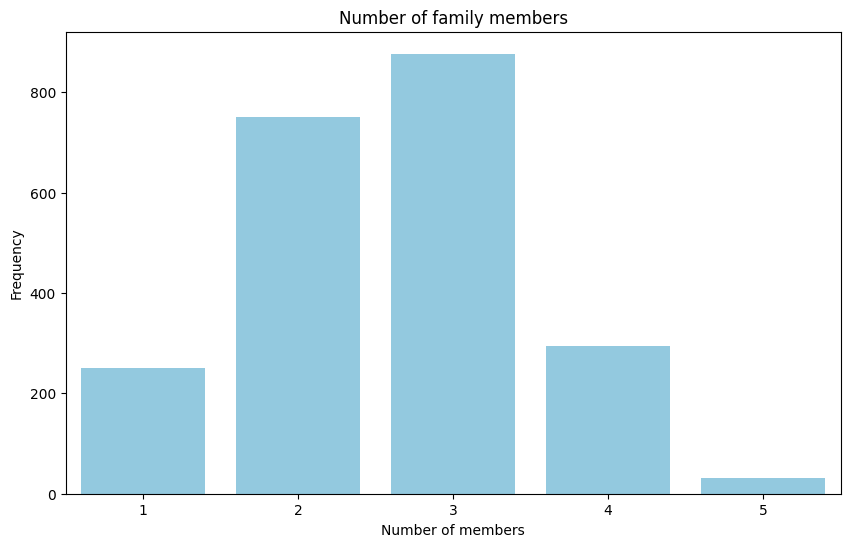

In [287]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.countplot(data=df, x='Family_Size', color='skyblue')
plt.title('Number of family members')
plt.xlabel('Number of members')
plt.ylabel('Frequency')
plt.show()

### 18) Do customers with a Master's degree spend more money on wine?
**No**, *as we can see in our plot customers with a **Ph.D. degree spend more** money on wine than customers with a Master's degree, on average.*

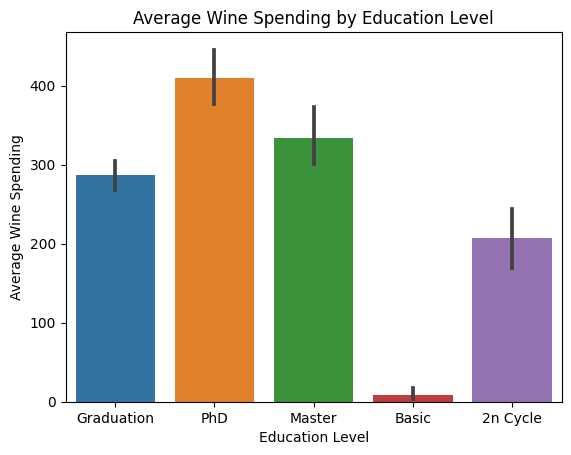

In [302]:
# Filter data for wine customers
wine_customers = df[df['MntWines']>0]

sns.barplot(data=wine_customers, x='Education', y='MntWines')
plt.title('Average Wine Spending by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Wine Spending')
plt.show()

## 7. Data Preprocessing with Label Encoding, Standardization, and PCA Dimensionality Reduction.



---



> ###  Label Encoding











In [303]:
from sklearn.preprocessing import LabelEncoder

# Select the categorical variables to encode
categories = ['Education', 'Marital_Status', 'Living_With']

# Before encoding
df[categories].head()

,Education,Marital_Status,Living_With
0,Graduation,Single,Alone
1,Graduation,Single,Alone
2,Graduation,Together,Partner
3,Graduation,Together,Partner
4,PhD,Married,Partner


In [304]:

# Initialize LabelEncoder object
le = LabelEncoder()

# Apply LabelEncoder to each categorical variable
for cat in categories:
    df[cat] = le.fit_transform(df[cat])

# After encoding
df[categories].head()

,Education,Marital_Status,Living_With
0,2,2,0
1,2,2,0
2,2,3,1
3,2,3,1
4,4,1,1


> ### Numeric-Only Copy of DataFrame without Promotional Actions Columns

In [307]:
# Copy the dataframe with only numerical columns
# df_num = df.select_dtypes(include='number').copy()

df_num = df[['Age', 'Family_Size', 'Income', 'MntWines', 'MntFishProducts', 'MntSweetProducts','MntGoldProds', 'Spent', 'NumDealsPurchases', 'NumWebPurchases', 
              'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']].copy()

# Drop columns related to offers and promotions
#drop_cols = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
#df_num.drop(drop_cols, axis=1, inplace=True)

df_num.head()

,Age,Family_Size,Income,MntWines,MntFishProducts,MntSweetProducts,MntGoldProds,Spent,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,66,1,58138.0,635,172,88,88,1617,3,8,10,4,7
1,69,3,46344.0,11,2,1,6,27,2,1,1,2,5
2,58,2,71613.0,426,111,21,42,776,1,8,2,10,4
3,39,3,26646.0,11,10,3,5,53,2,2,0,4,6
4,42,3,58293.0,173,46,27,15,422,5,5,3,6,5


> ### Standardization of Data

In [308]:
from sklearn.preprocessing import StandardScaler

# Standardize the numeric columns
scaler = StandardScaler()
df_num[df_num.columns] = scaler.fit_transform(df_num[df_num.columns])

# Print the resulting dataframe
df_num.head()

,Age,Family_Size,Income,MntWines,MntFishProducts,MntSweetProducts,MntGoldProds,Spent,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1.017189,-1.759012,0.314651,0.974566,2.449154,1.480301,0.849556,1.679323,0.361479,1.424772,2.628526,-0.562650,0.689203
1,1.273530,0.448513,-0.254877,-0.874776,-0.652345,-0.635399,-0.735767,-0.963897,-0.168834,-1.132957,-0.588043,-1.179732,-0.139645
2,0.333612,-0.655250,0.965354,0.355155,1.336263,-0.149031,-0.039771,0.281242,-0.699147,1.424772,-0.230646,1.288596,-0.554069
3,-1.289883,0.448513,-1.206087,-0.874776,-0.506392,-0.586763,-0.755100,-0.920675,-0.168834,-0.767567,-0.945440,-0.562650,0.274779
4,-1.033542,0.448513,0.322136,-0.394659,0.150396,-0.003121,-0.561768,-0.307248,1.422105,0.328602,0.126750,0.054432,-0.139645


> ### PCA Dimensionality Reduction

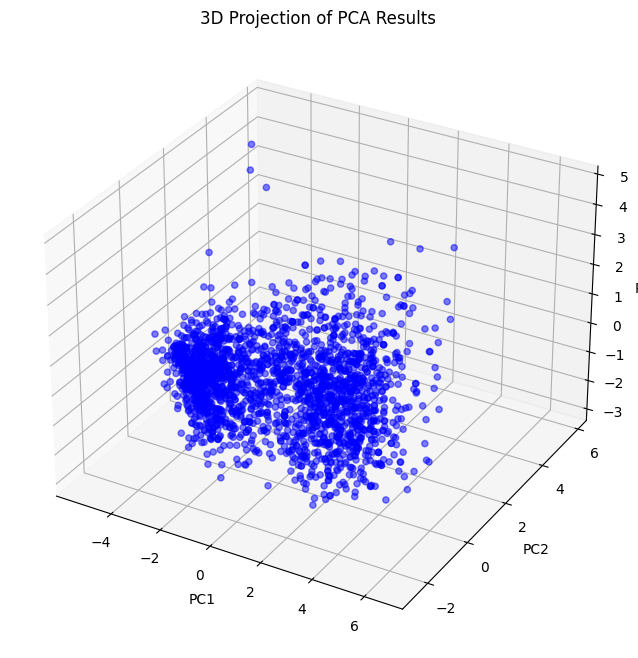

In [309]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA with n_components=3
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_num)

# Plot the 3D projection of the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], c='blue', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Projection of PCA Results')
plt.show()

## 8. Clustering


---



> ### Find the number of clusters using the elbow method* and plot the elbow.
*We observed that as the number of clusters increased, the amount of distortion in the K-means clustering decreased rapidly at first and then began to level off around k=3.*

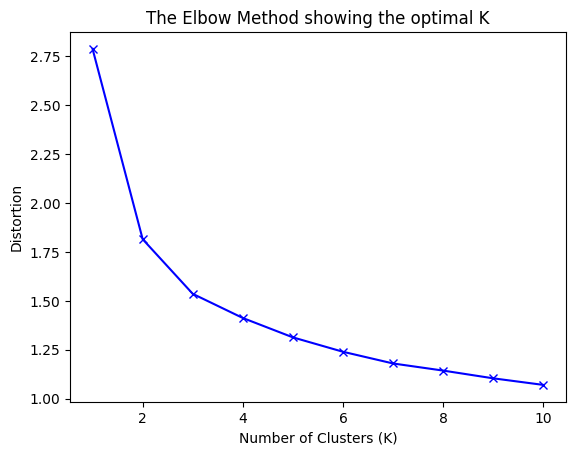

In [324]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np

distortions = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10).fit(df_pca)
    kmeanModel.fit(df_pca)
    distortions.append(sum(np.min(cdist(df_pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_pca.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal K')
plt.show()

### Cluster the data using K-means and Agglomerative
> *We selected 3 as the optimal number of clusters, since it is the point where the curve of the plot starts to level off significantly.*

<ipython-input-328-aca5ebc2b380>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1')


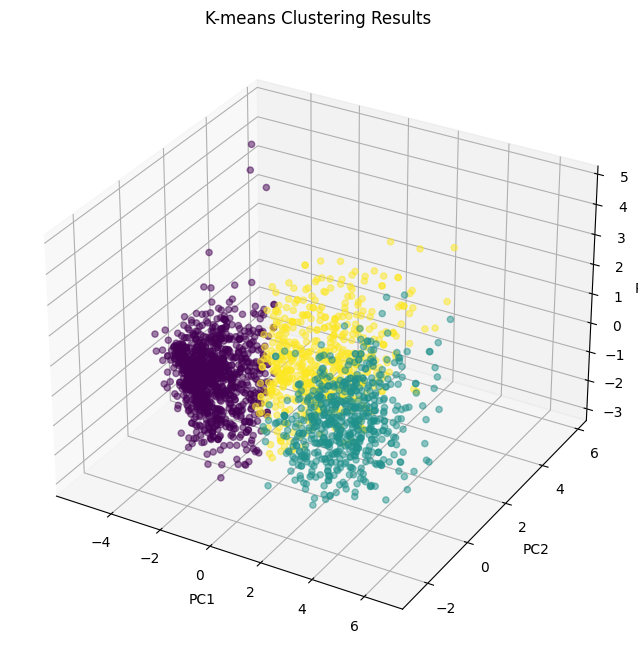

In [328]:
# Define the color map, to use it for both K-means and Agglomerative clustering
cmap = plt.cm.get_cmap('Set1')

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
labels = kmeans.fit_predict(df_num)

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], c=labels, cmap='viridis', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('K-means Clustering Results')
plt.show()

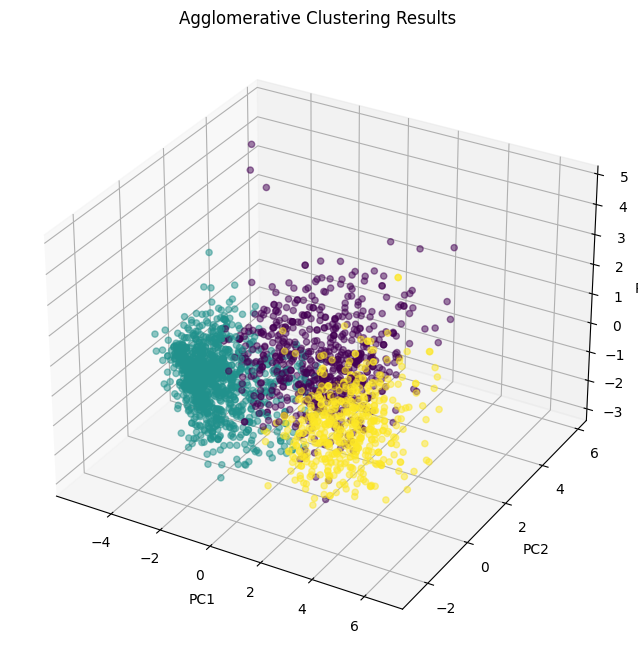

In [326]:
# Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=3)
labels = agglo.fit_predict(df_num)

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], c=labels, cmap='viridis', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering Results')
plt.show()

## 9) Customer Profiling
* **Profile 1** customers are the least significant among the three profiles. They have the lowest income and spend less compared to the other two profiles.Although they make the most web visits, they have the lowest web purchases.  They also have the lowest acceptance rate for marketing offers.
* **Profile 2** is the most significant customer profile as they have the highest income, spend the most, and make the most purchases, especially web purchases and catalog purchases, compared to the other two profiles. They also have the highest acceptance rate for marketing offers.
* **Profile 3** customers are in the middle range in terms of income, spending, and purchase behavior. They have the highest age and family size, and their acceptance rate for marketing offers is the same as Profile 2.

*We inspected the values visually using bar plots to help in understanding the data better.*


<Figure size 1000x800 with 0 Axes>

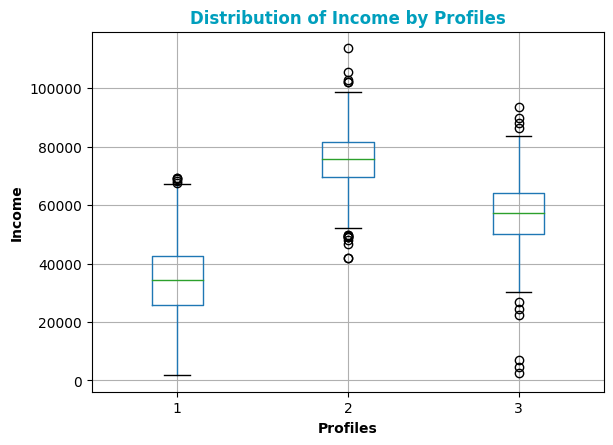

<Figure size 1000x800 with 0 Axes>

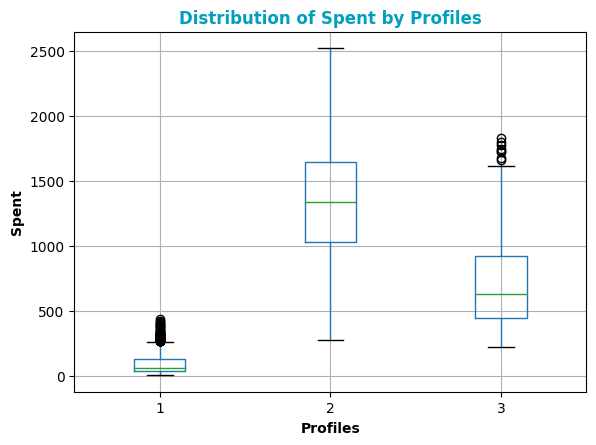

<Figure size 1000x800 with 0 Axes>

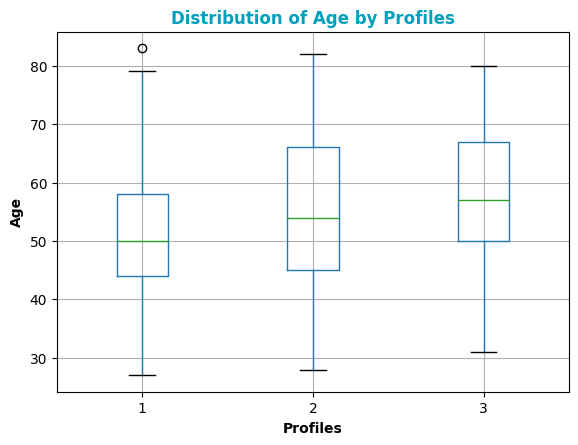

<Figure size 1000x800 with 0 Axes>

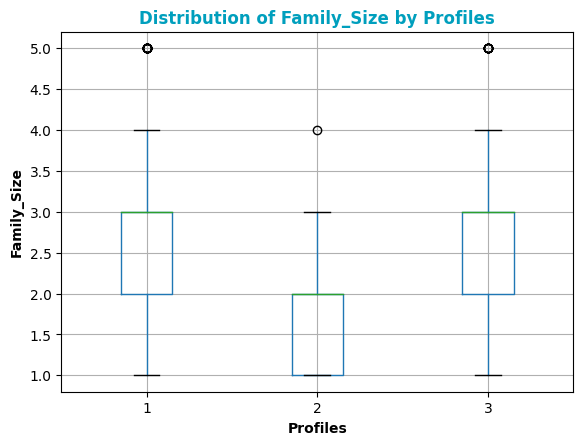

<Figure size 1000x800 with 0 Axes>

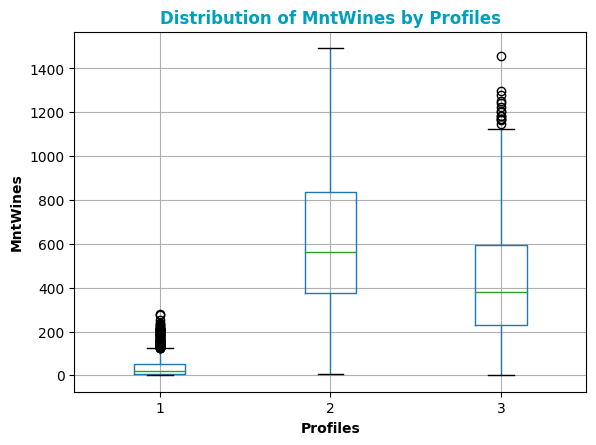

<Figure size 1000x800 with 0 Axes>

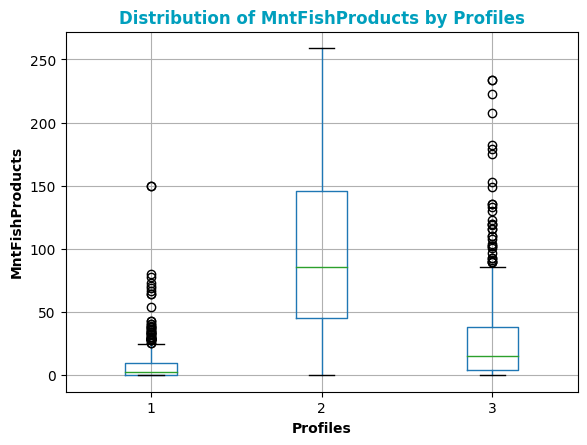

<Figure size 1000x800 with 0 Axes>

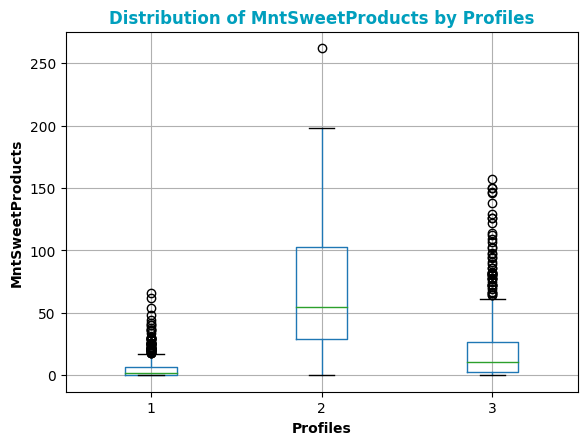

<Figure size 1000x800 with 0 Axes>

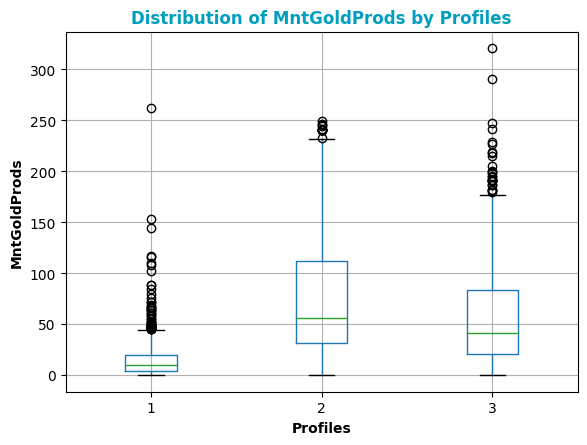

<Figure size 1000x800 with 0 Axes>

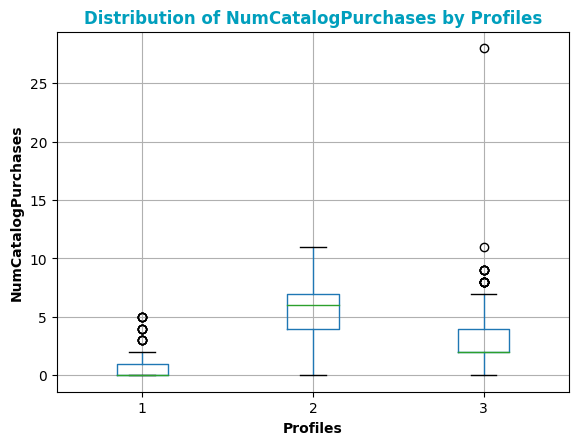

<Figure size 1000x800 with 0 Axes>

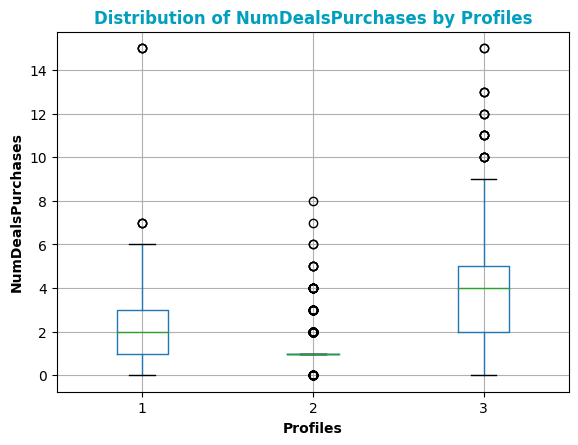

<Figure size 1000x800 with 0 Axes>

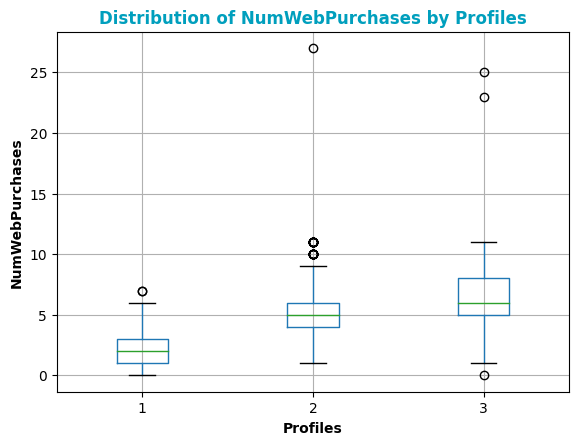

<Figure size 1000x800 with 0 Axes>

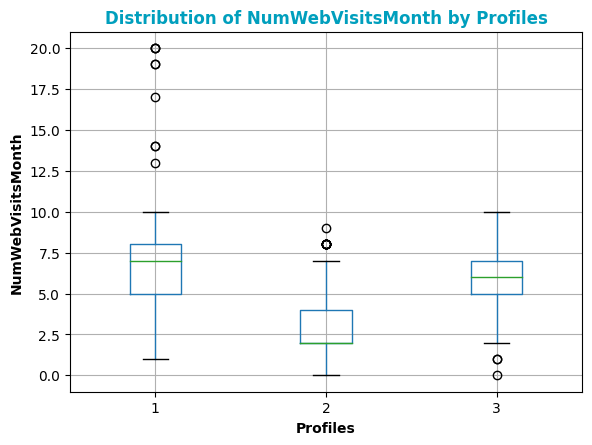

<Figure size 1000x800 with 0 Axes>

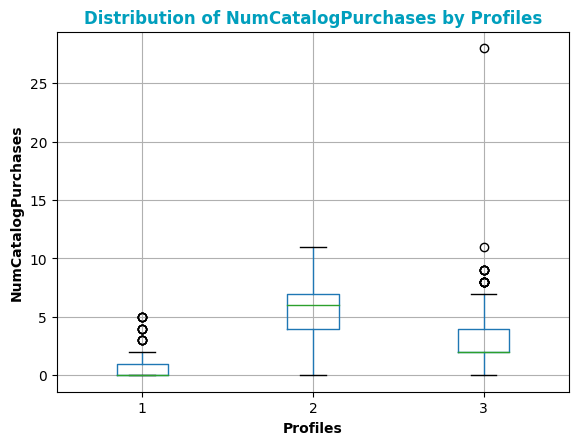

<Figure size 1000x800 with 0 Axes>

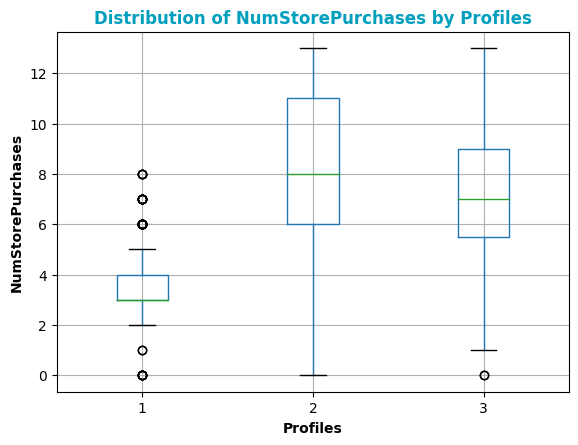

<Figure size 1000x800 with 0 Axes>

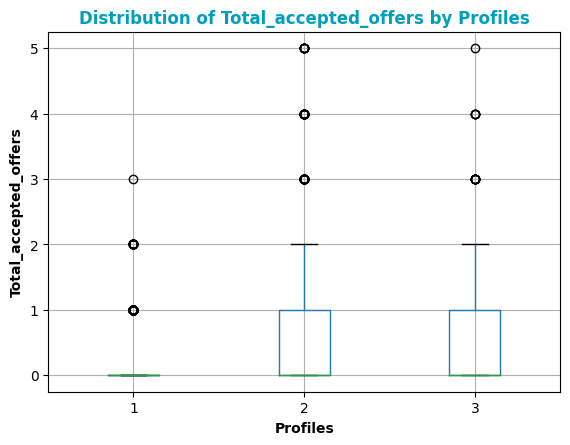

In [384]:
# Assign cluster labels to the df dataframe
df['Cluster'] = labels

# Map cluster labels to profile numbers
profile_dict = {0: 1, 1: 2, 2: 3}
df['Profile'] = df['Cluster'].map(profile_dict)

df['Total_accepted_offers'] = df[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']].sum(axis=1)
feature_list = ['Income', 'Spent', 'Age', 'Family_Size', 'MntWines', 'MntFishProducts', 'MntSweetProducts','MntGoldProds', 'NumCatalogPurchases' ,'NumDealsPurchases', 'NumWebPurchases', 'NumWebVisitsMonth',
              'NumCatalogPurchases', 'NumStorePurchases',  'Total_accepted_offers']

for feature in feature_list:
    plt.figure(figsize=(10,8))
    df_box = df[['Profile', feature]]
    bp = df_box.boxplot(by='Profile')
    plt.title(f'Distribution of {feature} by Profiles', fontweight='bold', color = "#009FBD")
    plt.xlabel('Profiles', fontweight='bold')
    plt.ylabel(feature, fontweight='bold')
    plt.suptitle('')
    plt.subplots_adjust(top=0.9)
    plt.show()
